In [38]:
# Importing necessary files
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot, figure
from pandas import read_csv, DataFrame, concat, to_datetime
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [43]:
#Importing the dataset, removing unnecessary variables, filling all NA's with 0 for FEDFUNDS
df = read_csv('ucsbdata.csv')
updated_dataset = df[['Index','OPEN', 'HIGH', 'LOW', 'CLOSE', 'PER', 'EPS', 'FEDFUNDS']]
updated_dataset['FEDFUNDS'].fillna(0, inplace=True)
# convert to datetime
updated_dataset['Index'] = to_datetime(df['Index'])
updated_dataset.info()
# set the index
df.set_index('Index', inplace=True)
df.info()
updated_dataset.to_csv('updated_ucsbdata.csv')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16863 entries, 0 to 16862
Data columns (total 8 columns):
Index       16863 non-null datetime64[ns]
OPEN        16863 non-null float64
HIGH        16863 non-null float64
LOW         16863 non-null float64
CLOSE       16863 non-null float64
PER         16863 non-null float64
EPS         16863 non-null float64
FEDFUNDS    16863 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.0 MB
<class 'pandas.core.frame.DataFrame'>
Index: 16863 entries, 1952-01-02 to 2018-12-31
Data columns (total 67 columns):
R                   9826 non-null float64
US10YR              14348 non-null float64
EPS                 16863 non-null float64
PER                 16863 non-null float64
OPEN                16863 non-null float64
HIGH                16863 non-null float64
LOW                 16863 non-null float64
CLOSE               16863 non-null float64
BDIY                8568 non-null float64
VIX                 7307 non-null float64
P

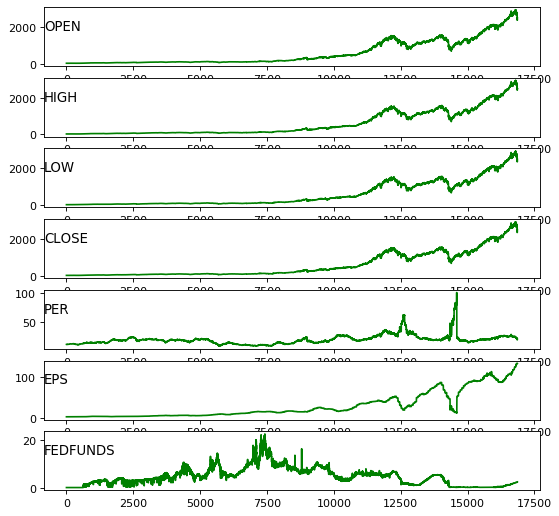

In [44]:
# Load dataset, specify variables to run plot function
dataset = read_csv('updated_ucsbdata.csv', header=0, index_col=0)
values = dataset.values
groups = [1, 2, 3, 4, 5, 6, 7]
i = 1
# Plot each column
pyplot.figure(num=None, figsize=(8, 8), dpi=80, facecolor='white', edgecolor='red')
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group], color = 'green')
    pyplot.title(dataset.columns[group], y=0.5, loc='left')
    i += 1
pyplot.show()

In [45]:
dataset.head()

,Index,OPEN,HIGH,LOW,CLOSE,PER,EPS,FEDFUNDS
0,1952-01-02,23.80,23.80,23.80,23.80,9.754098,2.44,0.0
1,1952-01-03,23.88,23.88,23.88,23.88,9.786885,2.44,0.0
2,1952-01-04,23.92,23.92,23.92,23.92,9.803279,2.44,0.0
3,1952-01-07,23.91,23.91,23.91,23.91,9.799180,2.44,0.0
4,1952-01-08,23.82,23.82,23.82,23.82,9.762295,2.44,0.0


In [47]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('updated_ucsbdata.csv', header=0, index_col=1)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.000374   0.000374   0.000375   0.003642   0.032609   
2   0.000059   0.000402   0.000401   0.000403   0.004151   0.032954   
3   0.000119   0.000415   0.000415   0.000417   0.004370   0.033127   
4   0.000178   0.000412   0.000411   0.000413   0.004297   0.033084   
5   0.000237   0.000381   0.000380   0.000382   0.003787   0.032695   

   var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
1        0.0  0.000059  0.000402  0.000401  0.000403  0.004151  0.032954   
2        0.0  0.000119  0.000415  0.000415  0.000417  0.004370  0.033127   
3        0.0  0.000178  0.000412  0.000411  0.000413  0.004297  0.033084   
4        0.0  0.000237  0.000381  0.000380  0.000382  0.003787  0.032695   
5        0.0  0.000297  0.000353  0.000353  0.000355  0.003350  0.032350   

    var7(t)  var8(t)  
1  0.000766      0.0  
2  0.000766      0.0  
3  0.000766      0.0  
4  0.000766      0.0  
5

In [48]:
# split into train and test sets
values = reframed.values
n_train_days = 13491
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13491, 1, 14) (13491,) (3371, 1, 14) (3371,)


Train on 13491 samples, validate on 3371 samples
Epoch 1/50
 - 3s - loss: 0.0769 - val_loss: 0.0556
Epoch 2/50
 - 1s - loss: 0.0735 - val_loss: 0.0726
Epoch 3/50
 - 1s - loss: 0.0545 - val_loss: 0.1288
Epoch 4/50
 - 1s - loss: 0.0531 - val_loss: 0.1209
Epoch 5/50
 - 1s - loss: 0.0388 - val_loss: 0.1430
Epoch 6/50
 - 1s - loss: 0.0401 - val_loss: 0.1015
Epoch 7/50
 - 1s - loss: 0.0376 - val_loss: 0.0714
Epoch 8/50
 - 1s - loss: 0.0334 - val_loss: 0.0676
Epoch 9/50
 - 1s - loss: 0.0320 - val_loss: 0.0621
Epoch 10/50
 - 1s - loss: 0.0301 - val_loss: 0.0605
Epoch 11/50
 - 1s - loss: 0.0282 - val_loss: 0.0592
Epoch 12/50
 - 1s - loss: 0.0275 - val_loss: 0.0581
Epoch 13/50
 - 1s - loss: 0.0263 - val_loss: 0.0563
Epoch 14/50
 - 1s - loss: 0.0259 - val_loss: 0.0540
Epoch 15/50
 - 1s - loss: 0.0252 - val_loss: 0.0528
Epoch 16/50
 - 1s - loss: 0.0245 - val_loss: 0.0520
Epoch 17/50
 - 1s - loss: 0.0241 - val_loss: 0.0509
Epoch 18/50
 - 1s - loss: 0.0236 - val_loss: 0.0502
Epoch 19/50
 - 1s - loss

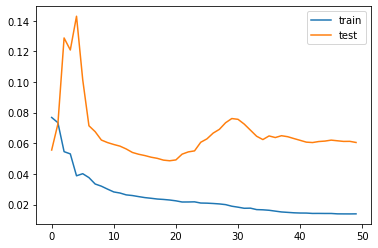

In [49]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [50]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (3371,14) (8,) (3371,14) 